# Project-level bbox and tindex

In [43]:
ICESAT2_BOREAL_REPO_PATH = '/projects/Developer/icesat2_boreal' #'/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'
!pip install -U -r $ICESAT2_BOREAL_REPO_PATH/dps/requirements_main.txt

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [44]:
from shapely.geometry import box
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import contextily as ctx
import os
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import maplib_folium
import ExtractUtils

# Define a basic project bbox for a min near 50N

In [45]:
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')
bbox_project = boreal_tiles.to_crs(4326).total_bounds
bbox_project[1] = 51.6
bbox_project

array([-179.8325521 ,   51.6       ,  178.39934685,   78.53132756])

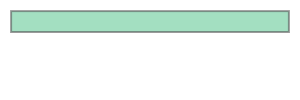

In [46]:
geom=box(*bbox_project)
geom

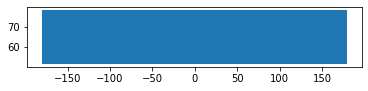

In [47]:
boreal_tiles.to_crs(4326).total_bounds

bbox_fn = '/projects/shared-buckets/nathanmthomas/project_bbox.gpkg'

gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[geom])
gdf['extent'] = 'boreal biomass domain'
gdf.plot()
gdf.to_file(bbox_fn, driver='GPKG')

# Select tiles for domain: BBOX min 50N

In [48]:
tindex_master_json_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json'
tindex_master_json_SUBSET_fn = os.path.splitext(tindex_master_json_fn)[0] + '_min50N.json'
tindex_master_mosaic_json_SUBSET_fn = os.path.splitext(tindex_master_json_fn)[0] + '_mosaic_min50N.json'

In [49]:
tindex_master_json_SUBSET_fn

'/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_min50N.json'

In [50]:
AGB_c2020_noground_tindex   = gpd.read_file(tindex_master_json_fn)

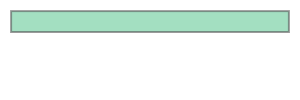

In [51]:
SUB_DOMAIN_selection_geometry = gdf.iloc[0].geometry # this is the same as 'geom'
SUB_DOMAIN_selection_geometry

In [52]:
selector = AGB_c2020_noground_tindex.intersects(SUB_DOMAIN_selection_geometry)

In [53]:
print("Subset by SUB_DOMAIN...")
selector = AGB_c2020_noground_tindex.intersects(SUB_DOMAIN_selection_geometry)
AGB_c2020_noground_tindex_min50N = AGB_c2020_noground_tindex[selector]
AGB_c2020_noground_tindex_min50N.to_file(tindex_master_json_SUBSET_fn, driver='GeoJSON')

Subset by SUB_DOMAIN...


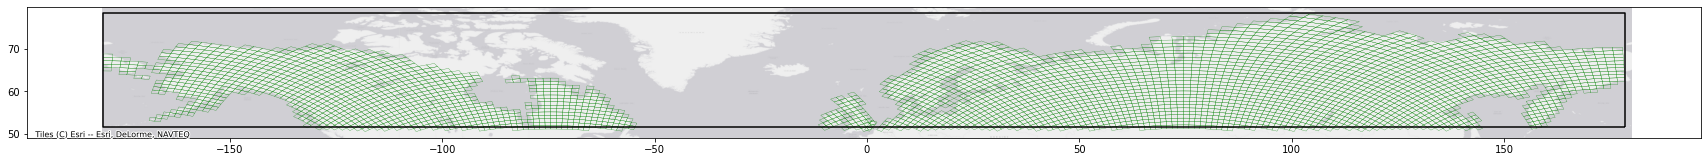

In [54]:
ax1 = AGB_c2020_noground_tindex_min50N.plot(facecolor='None', linewidth=0.25, ec='green', figsize=(30,10))
ax1 = gdf.boundary.plot(color='black', ax=ax1)
ax1 = ctx.add_basemap(ax1, crs=4326, 
            #source = ctx.providers.Esri.WorldShadedRelief
            source = ctx.providers.Esri.WorldGrayCanvas
            #source = ctx.providers.Esri.NatGeoWorldMap
            #source = ctx.providers.Esri.WorldImagery
        )

In [56]:
AGB_c2020_noground_tindex_min50N.total_bounds

array([-179.81819396,   50.47596222,  178.39934685,   78.53132756])

# Write Mosaic Json for min 50N tindex

In [27]:

def build_mosaic_json(input_tindex_gdf, input_json_fn, out_masic_json_fn):

    from cogeo_mosaic.mosaic import MosaicJSON
    from cogeo_mosaic.backends import MosaicBackend
    from typing import Dict


    def get_accessor(feature: Dict):
        """Return specific feature identifier."""
        return feature["properties"]["s3_path"]

    # Step 1 get the gdf of the tiles matches to the tindex master csv (from build_tindex_master.py on the dps_output)
    #tile_index_matches_gdf = get_tile_matches_gdf(tindex_master_fn, boreal_tile_index_path = boreal_tile_index_path, BAD_TILE_LIST = BAD_TILE_LIST, cols_list = cols_list)

    # Step 2 get the tiles json rfom the gdf of matched tiles
    tile_matches_geojson = ExtractUtils.build_tiles_json(input_tindex_gdf, input_json_fn, SHOW_MAP=True)

    print(f"Building {out_masic_json_fn}")
    mosaicdata = MosaicJSON.from_features(tile_matches_geojson.get('features'), minzoom=6, maxzoom=18, accessor=get_accessor)

    with MosaicBackend(out_masic_json_fn, mosaic_def=mosaicdata) as mosaic:
        mosaic.write(overwrite=True)

Building /projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_mosaic_min50N.json


/projects/.local/lib/python3.7/site-packages/mercantile/__init__.py:79: FutureWarning: Mercantile 2.0 will require tile x and y to be within the range (0, 2 ** zoom)
  FutureWarning,


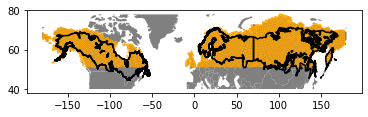

In [31]:
build_mosaic_json(AGB_c2020_noground_tindex_min50N, tindex_master_json_SUBSET_fn, tindex_master_mosaic_json_SUBSET_fn)

# Select tiles for domain: BOREAL

In [33]:
tindex_master_json_SUBSETBOREAL_fn = os.path.splitext(tindex_master_json_fn)[0] + '_boreal.json'
tindex_master_mosaic_json_SUBSETBOREAL_fn = os.path.splitext(tindex_master_json_fn)[0] + '_mosaic_boreal.json'


# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
boreal_gdf.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

In [23]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector_boreal = AGB_c2020_noground_tindex.to_crs(4326).intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
AGB_c2020_noground_tindex_BOREAL = AGB_c2020_noground_tindex.to_crs(4326)[selector_boreal]

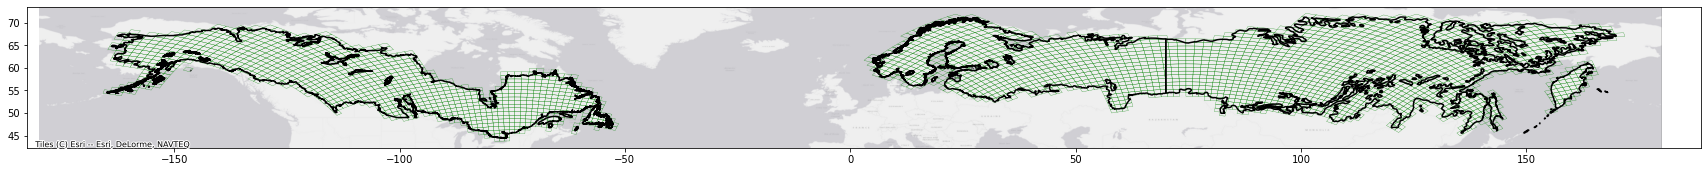

In [40]:
ax2 = AGB_c2020_noground_tindex_BOREAL.boundary.plot(linewidth=0.25, color='green', figsize=(30,10))
ax2 = boreal_gdf.boundary.plot(color='black', ax=ax2)
ax2 = ctx.add_basemap(ax2, crs=4326, 
            #source = ctx.providers.Esri.WorldShadedRelief
            source = ctx.providers.Esri.WorldGrayCanvas
            #source = ctx.providers.Esri.NatGeoWorldMap
            #source = ctx.providers.Esri.WorldImagery
        )

Building /projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master_mosaic_boreal.json


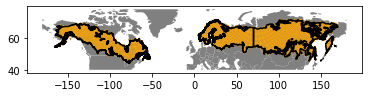

In [34]:
AGB_c2020_noground_tindex_BOREAL.to_file(tindex_master_json_SUBSETBOREAL_fn, driver='GeoJSON')
build_mosaic_json(AGB_c2020_noground_tindex_BOREAL, tindex_master_json_SUBSETBOREAL_fn, tindex_master_mosaic_json_SUBSETBOREAL_fn)